<a href="https://colab.research.google.com/github/konstantin-gm/Steering/blob/master/model_steer_utcr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
url = f"https://raw.githubusercontent.com/konstantin-gm/Steering/master/ctrl_funcs.py"
!wget --no-cache --backups=1 {url}
url = f"https://raw.githubusercontent.com/konstantin-gm/Steering/master/stable_funcs.py"
!wget --no-cache --backups=1 {url}

import numpy
from scipy import linalg
import matplotlib.pyplot as plt
from ctrl_funcs import *
from stable_funcs import *

--2023-04-16 20:10:27--  https://raw.githubusercontent.com/konstantin-gm/Steering/master/ctrl_funcs.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 844 [text/plain]
Saving to: ‘ctrl_funcs.py’

ctrl_funcs.py       100%[===================>]     844  --.-KB/s    in 0s      

2023-04-16 20:10:27 (67.3 MB/s) - ‘ctrl_funcs.py’ saved [844/844]

--2023-04-16 20:10:27--  https://raw.githubusercontent.com/konstantin-gm/Steering/master/stable_funcs.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1463 (1.4K) [text/plain]
Saving to: ‘st

In [ ]:
class Model:
    def __init__(self, free_noise, ref_noise, control, dt, ctrl_interval, drift):
        self.free_noise = free_noise
        self.ref_noise = ref_noise
        self.free_Q = covar_by_noise(free_noise, dt)
        self.free_L = linalg.cholesky(self.free_Q)
        self.ref_Q  = covar_by_noise(ref_noise, dt)
        self.ref_L = linalg.cholesky(self.ref_Q)
        self.G = control
        self.dt = dt
        self.ctrl_interval = ctrl_interval
        self.drift = drift
        
    def calculate(self, Xlock, Xfree, Xref, N):
        self.output = numpy.zeros([N, 1])
        self.ref = numpy.zeros((N, 1))
        self.free = numpy.zeros((N, 1))
        self.dphi = numpy.zeros((N, 1))
        
        F = numpy.array([[1, dt], 
                         [0, 1]])
        B = numpy.array([[dt], 
                         [1]])
        H = numpy.array([[1, 0]])
        D = numpy.array([[0.5*dt**2], 
                         [dt]])
        
        R = self.ref_noise[0]**2 + self.free_noise[0]**2
        P = numpy.array([[R, 0], 
                         [0, self.free_noise[1]**2]])
        
        qK = []
        zlist = []
        t = numpy.linspace(0, 6, 7) * 86400.
        
        u = 0        
        last_u = 0
        dX = numpy.zeros([2, 1])
        dXpred = numpy.zeros([2, 1])
        dXctrl = numpy.zeros([2, 1])
        phase = []
        freq = []
        
        acc = 0
        for i in range(N):
            
            free_w = numpy.random.randn(2, 1)
            ref_w = numpy.random.randn(2, 1)
            Xlock = F@Xlock + self.free_L@free_w + B*u + D*self.drift
            Xfree = F@Xfree + self.free_L@free_w + D*self.drift
            Xref = F@Xref + self.ref_L@ref_w
            
            
            wpn_free = numpy.random.randn(1)*self.free_noise[0]
            wpn_ref = numpy.random.randn(1)*self.ref_noise[0]
            
            self.output[i] = Xlock[0] + wpn_free
            self.free[i] = Xfree[0] + wpn_free
            self.ref[i] = Xref[0] + wpn_ref #+ 1e-9*numpy.cos(2*numpy.pi*i*dt/86400./2.)
            
            z = (Xlock[0] + wpn_free) - (Xref[0] + wpn_ref) 
            zlist.append(z[0])

            #print('1', dX)
            dXpred = F @ dX + B*u
            #print('2', dXpred)
            Ppred = F @ P @ F.T + self.free_Q + self.ref_Q
            
            K = Ppred @ H.T / (H @ Ppred @ H.T + R)
            #print('3', K)
            dX = dXpred + K*(z[0] - H @ dXpred)
            #print('4', dX)
            P = (numpy.eye(2) - numpy.outer(K, H)) @ Ppred
            
            qK.append(dX)            
                        
#           Управление
            if len(zlist) >= 11:
                #dXctrl = qK[6]
                tmp_array = numpy.array(zlist[0:7])
                #tmp_array[0:3] -= last_u*numpy.array([3, 2, 1])*86400
                c = numpy.polyfit(t[-7:], tmp_array[-7:], 1) #аппроксимация линией
                dXctrl[0] = (c[1] + c[0]*(t[-1] + 4*86400))        #экстраполяция отклонения шкалы на момент управления (четверг)
                dXctrl[1] = c[0] # считаем, что частота остается такая же на момент управления
                
                #for k in  range(4):
                #    dXctrl = F @ dXctrl
                   
                u = -self.G @ dXctrl      
                acc += 1e-1*u
                u += acc
                #print(u)
                last_u = u
                        
            #print(dX)
            #print('')
            #print(-self.G, dX, -self.G @ dX)                
            else:
                u = 0
                
            if len(qK) >= 11:
                qK = qK[7:]
            if len(zlist) >= 11:
                zlist = zlist[7:]
                #print(zlist)
            
            self.dphi[i] = z
            phase.append(dX[0])
            freq.append(dX[1])
            
        return self.output, self.ref, self.free, self.dphi, phase, freq

[gx, gy] =  [4.19025060e-07 7.53403036e-01]
Среднее отклонение шкалы времени: -9.26259881313996e-11
СКО разности шкал времени: 3.179777523724343e-09


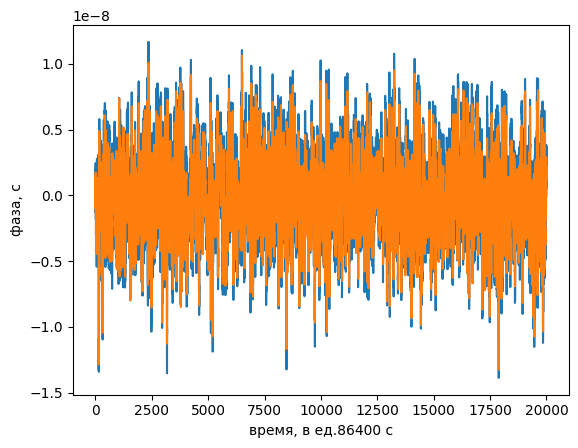

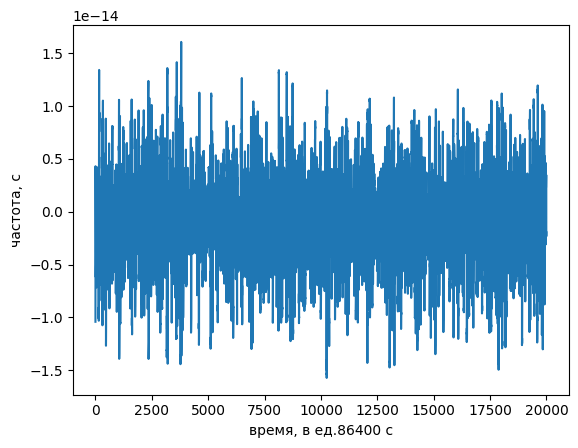

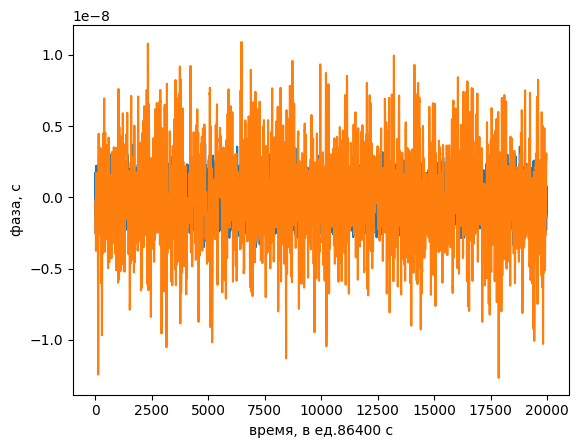

In [ ]:
PHM_noise = (numpy.sqrt(9e-26), numpy.sqrt(1e-25), numpy.sqrt(8.3e-37))
GNSS_noise = (numpy.sqrt(1e-18), 1e-50, 1e-60) #WPN reference
dt = 86400
steer_dt = 7*dt
T =10*dt
#    G = LQG_coef(T, dt)
G = crit_coef(T, steer_dt)
print('[gx, gy] = ', G)
model = Model(PHM_noise, GNSS_noise, G, dt, 7, 1e-16/86400)
Xlock = numpy.zeros([2, 1])
Xfree = numpy.zeros([2, 1])
Xref = numpy.zeros([2, 1])
x, ref, free, dphi, kphase, kfreq = model.calculate(Xlock, Xfree, Xref, 20000)
plt.figure(1)
t_tr = 0
plt.plot(dphi[t_tr:])
plt.plot(kphase[t_tr:])
plt.xlabel("время, в ед." + str(dt) + " c")
plt.ylabel("фаза, с")
plt.figure(4)
t_tr = 0
plt.plot(kfreq[t_tr:])
plt.xlabel("время, в ед." + str(dt) + " c")
plt.ylabel("частота, с")
plt.figure(2)
t_tr = 30
plt.plot(ref[t_tr:])
plt.plot(x[t_tr:])
plt.xlabel("время, в ед." + str(dt) + " c")
plt.ylabel("фаза, с")
print(f'Среднее отклонение шкалы времени: {numpy.mean(x[t_tr:])}')
print(f'СКО разности шкал времени: {numpy.std(x[t_tr:])}')

Text(0.5, 1.0, 'Переходный процесс исключен: 30.0 сут.')

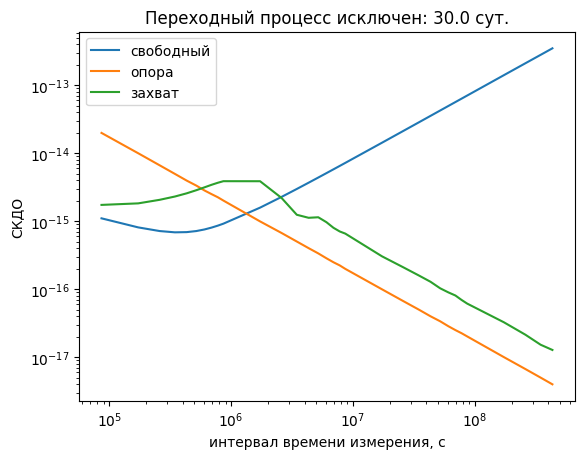

In [ ]:
tau = generate_tau(6)
t_tr = 30
taus, adev_lock = allan_deviation(x[t_tr:-1,0], dt, tau)
taus, adev_free = allan_deviation(free[t_tr:-1,0], dt, tau)
taus, adev_ref = allan_deviation(ref[t_tr:-1,0], dt, tau)
plt.figure(3)
plt.loglog(taus, adev_free)
plt.loglog(taus, adev_ref)
plt.loglog(taus, adev_lock)
plt.legend(["свободный","опора","захват"])
plt.xlabel("интервал времени измерения, c")
plt.ylabel("СКДО")
plt.title("Переходный процесс исключен: " + str(numpy.round(t_tr*dt/86400)) + " сут.")